<a href="https://colab.research.google.com/github/yesdeepakmittal/image-features-analysis/blob/main/Image_feature_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adverstisement creativity Recognition with Computer Vision

*Problem Description*:
Develop an advanced Computer Vision solution capable of identifying whether an image is an advertising creative or not. This task involves detecting visual patterns and features commonly associated with advertisements.

*Approach*:
1. **Data Collection**: In this project, I will use two sets of data. One set will be for `ad-creative` images and another set will be for `non-ad creative`.

    - `ad-creative`(class=1):
        - `PeterBrendan/AdImageNet` dataset from `HuggingFace`

            I will use `1000` images from this dataset
            - training: `700`(original) + `700`(Augmented from original images)
            - validation: `150`(original)
            - testing: `150`(original)
    - `non-ad creative`(class=0):
        - `viola77data/recycling-dataset` from `HuggingFace`: `200` images from this dataset

        - `TheBirdLegacy/DALL-E-Cats` from `HuggingFace`: `200` images from this dataset
        - `AI-Lab-Makerere/beans` from `HuggingFace`: `200` images from this dataset
        - `keremberke/painting-style-classification` from `HuggingFace`: `200` images from this dataset
        - `nroggendorff/flowers` from `HuggingFace`: `200` images from this dataset

            - training: `700`(original)
            - validation: `150`(original)
            - testing: `150`(original)

    Note: `ad-creative` contains augmented images with double the size of `non-ad creative` images to intentionally demonstrate the `Data Augmentation` & `Class Imbalance` problem.
    
2. **Data Preparation**: Below-mentioned transformations are applied on the images:
    - All images are convert to `RGB`(including grayscale)
    - Resizing every image to `256 x 256`
    - Centercrop to `224 x 224`
    - Out of 6 Data Augmentation techniques mentioned in this project, a random augmentation technique will be applied to generate an augmented image.
    - Tensor is normalized with the standard ImageNet configuration.

3. **Modelling**: In this project, we will target to solve 3 problems:
    - **Image Classification**: We will use a `CNN variant` for feature extraction and add a linear classifier for image classification.
    - **Object Detection**: To identify the logos or product images, we will use an object detection model(`YOLO variant`).
    - **Multimodal**: To incorporate textual information, we will use a multimodal like `LayoutLM variant` for the classfication along with an `OCR` like `Tesseract` or `Google Vision`.
    - **Color Scheme Analysis**: To analyse the color scheme, we will analyze the distribution of colors by generating histograms.

In [ ]:
!pip install -q datasets transformers

In [ ]:
# Importing libraries for data collection and preprocessing
import io
import random

import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
from torch.utils.data import TensorDataset
import torch.utils.data as torch_data


from datasets import load_dataset
from transformers import AutoTokenizer

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from huggingface_hub import login

# Log in to Hugging Face and generate a user access token
# Visit https://huggingface.co/settings/tokens to create a token
login()

In [ ]:
data_link = 'PeterBrendan/AdImageNet'

dataset = load_dataset(data_link, split='train')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


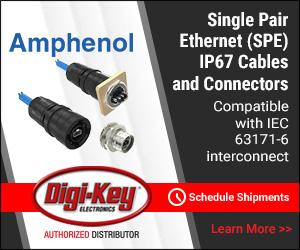

In [ ]:
# Select an image from the dataset
image_data = dataset[2]['image']
image_data

In [ ]:
image_data.size

(300, 250)

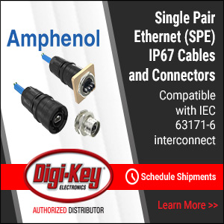

In [ ]:
image_data.resize((224, 224))

In [ ]:
# dataset size
len(dataset)

9003

In [ ]:
dataset = dataset.select(range(1000))
len(dataset)

1000

In [ ]:
# Function to convert grayscale to RGB
# def convert_grayscale_to_rgb(image):
#     if image.mode != 'RGB':
#         return image.convert('RGB')
#     return image

def convert_grayscale_to_rgb(image):
    if isinstance(image, torch.Tensor):
        # Check if the tensor has 3 channels (shape: [C, H, W])
        if image.size(0) == 3:
            return image
        else:
            # Convert single-channel tensor to 3-channel tensor by repeating the channel dimension
            return image.repeat(3, 1, 1)
    else:
        # If the input is a PIL Image, convert to RGB
        if image.mode != 'RGB':
            return image.convert('RGB')
        return image

# Define the transformations
transform_original = transforms.Compose([
    transforms.Resize((256, 256)),                   # Resize to 256x256
    transforms.CenterCrop(224),                      # Center crop to 224x224
    transforms.Lambda(lambda img: convert_grayscale_to_rgb(img)),  # Convert grayscale to RGB
    transforms.ToTensor(),                           # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # Normalize with mean and std
                         std=[0.229, 0.224, 0.225])
])

# Define the transformations for Image Augmentation
transform_aug = transforms.Compose([
    transforms.Resize((256, 256)),                   # Resize to 256x256
    transforms.CenterCrop(224),                      # Center crop to 224x224
    transforms.Lambda(lambda img: convert_grayscale_to_rgb(img)),  # Convert grayscale to RGB
    transforms.RandomChoice([
        transforms.RandomHorizontalFlip(p=0.5),      # Random horizontal flip with 50% probability
        transforms.RandomVerticalFlip(p=0.5),        # Random vertical flip with 50% probability
        transforms.RandomRotation(degrees=45),       # Random rotation within 45 degrees
        transforms.ColorJitter(brightness=0.5,       # Random change in brightness, contrast, saturation, and hue
                               contrast=0.5,
                               saturation=0.5,
                               hue=0.1),
        transforms.RandomGrayscale(p=0.1),           # Randomly convert images to grayscale with 10% probability
        transforms.RandomAffine(degrees=30,          # Random affine transformations with 30 degrees rotation
                                translate=(0.1, 0.1),
                                scale=(0.8, 1.2),
                                shear=10),
    ]),
    transforms.ToTensor(),                           # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # Normalize with mean and std
                         std=[0.229, 0.224, 0.225])
])

# Apply transformations using Dataset and DataLoader
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None, label=1):
        self.dataset = dataset
        self.transform = transform
        self.label = label

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # sample = self.dataset[idx]
        # sample['image'] = self.transform(sample['image'])
        # return sample['image'], torch.tensor(self.label, dtype=torch.long)
        sample = self.dataset[idx]
        # Check if 'image' is already a tensor
        if not isinstance(sample['image'], torch.Tensor):
            sample['image'] = self.transform(sample['image'])  # Apply transform only if not a tensor
        return sample['image'], torch.tensor(self.label, dtype=torch.long)

### Splitting dataset for Training, Validation, and Testing

In [ ]:
def train_val_test_split(dataset):
    # Define the sizes for training, validation, and testing sets
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    # Set a random seed for reproducibility
    random.seed(42)

    # Generate indices and shuffle
    indices = list(range(len(dataset)))
    random.shuffle(indices)

    # Split indices
    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]
    test_indices = indices[train_size + val_size:]

    # Create subsets using Subset class from PyTorch
    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    test_dataset = Subset(dataset, test_indices)

    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = train_val_test_split(dataset)

print(f"Training set length:{len(train_dataset)}")
print(f"Validation set length:{len(val_dataset)}")
print(f"Testing set length:{len(test_dataset)}")

Training set length:700
Validation set length:150
Testing set length:150


In [ ]:
train_transformed_dataset = CustomDataset(train_dataset, transform=transform_original, label=1)
val_transformed_dataset = CustomDataset(val_dataset, transform=transform_original, label=1)
test_transformed_dataset = CustomDataset(test_dataset, transform=transform_original, label=1)
train_augmented_dataset = CustomDataset(train_dataset, transform=transform_aug, label=1)

# Combine transformed training dataset with augmented dataset
combined_train_dataset = ConcatDataset([train_transformed_dataset, train_augmented_dataset])

In [ ]:
len(combined_train_dataset)

1400

In [ ]:
# # Apply the transformations
# transformed_image = transform_original(image_data)

# # Convert the transformed tensor back to a PIL image for visualization
# transformed_image_pil = transforms.ToPILImage()(transformed_image)

# # Display the original and transformed images
# fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# axes[0].imshow(image_data)
# axes[0].set_title("Original Image")
# axes[0].axis('off')

# axes[1].imshow(transformed_image_pil)
# axes[1].set_title("Transformed(Original) Image")
# axes[1].axis('off')

# plt.show()

In [ ]:
# # Apply the transformations
# transformed_image = transform_aug(image_data)

# # Convert the transformed tensor back to a PIL image for visualization
# transformed_image_pil = transforms.ToPILImage()(transformed_image)

# # Display the original and transformed images
# fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# axes[0].imshow(image_data)
# axes[0].set_title("Original Image")
# axes[0].axis('off')

# axes[1].imshow(transformed_image_pil)
# axes[1].set_title("Transformed(Augmented) Image")
# axes[1].axis('off')

# plt.show()

In [ ]:
# Load and limit each non-ad creative dataset to 200 examples
num_samples_per_dataset = 200

# Load and limit first dataset
non_ad_link = 'viola77data/recycling-dataset'
non_ad_dataset = load_dataset(non_ad_link, split='train')
non_ad_dataset = non_ad_dataset.select(range(num_samples_per_dataset))

# Load and limit second dataset
non_ad_link_2 = 'TheBirdLegacy/DALL-E-Cats'
non_ad_dataset_2 = load_dataset(non_ad_link_2, split='train')
non_ad_dataset_2 = non_ad_dataset_2.select(range(num_samples_per_dataset))

# Load and limit third dataset
non_ad_link_3 = 'AI-Lab-Makerere/beans'
non_ad_dataset_3 = load_dataset(non_ad_link_3, split='train')
non_ad_dataset_3 = non_ad_dataset_3.select(range(num_samples_per_dataset))

# Load and limit fourth dataset
non_ad_link_4 = 'keremberke/painting-style-classification'
non_ad_dataset_4 = load_dataset(non_ad_link_4, name="full", split='train')
non_ad_dataset_4 = non_ad_dataset_4.select(range(num_samples_per_dataset))

# Load and limit fifth dataset
non_ad_link_5 = 'nroggendorff/flowers'
non_ad_dataset_5 = load_dataset(non_ad_link_5, split='train')
non_ad_dataset_5 = non_ad_dataset_5.select(range(num_samples_per_dataset))

Resolving data files:   0%|          | 0/3107 [00:00<?, ?it/s]

In [ ]:
all_non_ad = []
for ds in [non_ad_dataset, non_ad_dataset_2, non_ad_dataset_3, non_ad_dataset_4, non_ad_dataset_5]:
    for sample in ds:
        try:
            image = Image.fromarray(sample['image']) if isinstance(sample['image'], np.ndarray) else sample['image']
        except:
            image = Image.fromarray(sample['Images']) if isinstance(sample['Images'], np.ndarray) else sample['Images']
        all_non_ad.append({'image':image})

train_non_ad_dataset, val_non_ad_dataset, test_non_ad_dataset = train_val_test_split(all_non_ad)

print(f"Training set length:{len(train_non_ad_dataset)}")
print(f"Validation set length:{len(val_non_ad_dataset)}")
print(f"Testing set length:{len(test_non_ad_dataset)}")

train_non_ad_dataset = CustomDataset(train_non_ad_dataset, transform=transform_original, label=0)
val_non_ad_dataset = CustomDataset(val_non_ad_dataset, transform=transform_original, label=0)
test_non_ad_dataset = CustomDataset(test_non_ad_dataset, transform=transform_original, label=0)

Training set length:700
Validation set length:150
Testing set length:150


In [ ]:
# Merging ad-creative & non-ad creative datasets
combined_train_dataset = ConcatDataset([combined_train_dataset, train_non_ad_dataset])
combined_val_dataset = ConcatDataset([val_transformed_dataset, val_non_ad_dataset])
combined_test_dataset = ConcatDataset([test_transformed_dataset, test_non_ad_dataset])

# Create DataLoader instances for the combined datasets
train_loader = DataLoader(combined_train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(combined_val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(combined_test_dataset, batch_size=32, shuffle=False)

In [ ]:
len(combined_train_dataset), len(combined_val_dataset), len(combined_test_dataset)

(2100, 300, 300)

In [ ]:
for batch in val_loader:
    print(batch[0].shape)
    print(batch[0][0].shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([3, 224, 224])


### Training Binary classifier using ResNet50 for feature extraction

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import accuracy_score, confusion_matrix
from torch.optim.lr_scheduler import StepLR

# Define the ResNet50 model for feature extraction
class ResNet50Classifier(nn.Module):
    def __init__(self):
        super(ResNet50Classifier, self).__init__()
        self.resnet50 = models.resnet50(pretrained=True)
        self.resnet50.fc = nn.Linear(self.resnet50.fc.in_features, 2)  # Binary classification

    def forward(self, x):
        return self.resnet50(x)

model = ResNet50Classifier()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Define Loss Function and Optimizer

In [ ]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_weights = torch.tensor([1.0, 2.0], dtype=torch.float).to(device)  # Adjust weights based on class imbalance
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

### Model Training

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/25, Train Loss: 0.1981, Train Accuracy: 0.9210, Val Loss: 1.2318, Val Accuracy: 0.8100
Epoch 2/25, Train Loss: 0.0870, Train Accuracy: 0.9605, Val Loss: 0.0677, Val Accuracy: 0.9767
Epoch 3/25, Train Loss: 0.0978, Train Accuracy: 0.9600, Val Loss: 0.0362, Val Accuracy: 0.9900
Epoch 4/25, Train Loss: 0.0462, Train Accuracy: 0.9819, Val Loss: 0.2563, Val Accuracy: 0.9133
Epoch 5/25, Train Loss: 0.0568, Train Accuracy: 0.9762, Val Loss: 0.1839, Val Accuracy: 0.9600
Epoch 6/25, Train Loss: 0.0454, Train Accuracy: 0.9800, Val Loss: 0.0968, Val Accuracy: 0.9667
Epoch 7/25, Train Loss: 0.0319, Train Accuracy: 0.9890, Val Loss: 0.0200, Val Accuracy: 0.9933
Epoch 8/25, Train Loss: 0.0158, Train Accuracy: 0.9948, Val Loss: 0.0113, Val Accuracy: 0.9933
Epoch 9/25, Train Loss: 0.0134, Train Accuracy: 0.9938, Val Loss: 0.0111, Val Accuracy: 0.9967
Epoch 10/25, Train Loss: 0.0105, Train Accuracy: 0.9976, Val Loss: 0.0138, Val Accuracy: 0.9967
Epoch 11/25, Train Loss: 0.0061, Train Accuracy: 

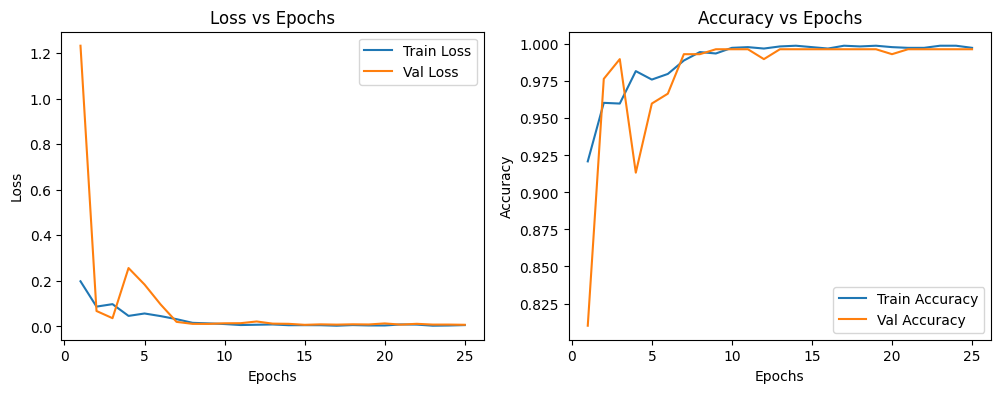

In [ ]:
# Move model to the GPU
model.to(device)

num_epochs = 25
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        # Move inputs and labels to the GPU
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / total
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            # Move inputs and labels to the GPU
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= total
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    scheduler.step()

# Plot Loss and Accuracy
epochs = range(1, num_epochs+1)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Epochs')

plt.show()

### Evaluate the Model on Test Set

In [ ]:
model.eval()
test_loss = 0.0
correct = 0
total = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        # Move inputs and labels to the GPU
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

test_loss /= total
test_accuracy = correct / total

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)
print('Confusion Matrix:')
print(cm)

Test Loss: 0.0237, Test Accuracy: 0.9967
Confusion Matrix:
[[150   0]
 [  1 149]]
